# **Data Analysis For Wellseley Pressure Sweep Data**

This Contains the analysis and code for plotting Wellseley's SAQ Test Stand Calibration data. This code is designed to pull from a folder called "Data" which is also in this github, and contains the data in the form of root files:

## 1. Reading from Root files and getting Timestamps of Resets:
   
 - Parsing information from the 16 channels
 - Discarding the first packet from the zybo (this was a bug that would keep the left over timestamp from the last run if the GUI wasnt closed properly)
 - Converting from Zybo-timestamp to timestamp in seconds
 - Saving it all to a 3d list

## 2. Plot the Number of Resets vs Time:
   
 - Plotting how many resets are coming in over time so you can see if there are any stops in the data where resets werent being collected
   
## 3. Get the Reset Time differences and plotting:

 - Getting the reset time differences (RTDs) from the timestamps
 - Finding the mean RTD and 1 standard deviation and saving that information


In [1]:
import matplotlib.pyplot as plt
import ast
import numpy as np
import  os
from pathlib import Path
import os
import sys
import ROOT
import numpy as np
from SAQ_DAQ import N_SAQ_CHANNELS

Welcome to JupyROOT 6.26/04


In [2]:
# Set Torr Values
torrList=[200,250,300,250,400,450,500,550,600,650,700,760]

## 1. Reading From Root Files and getting Timestamps of Resets:

In [3]:
def fix_wrap_around(times):
    """
    update timestamp values from the zybo
    every timestamp that is less than the previous indicates a 'wrap around'
    """

    wrap_val = 2**32
    n_wrap = 0
    inc_times = [times[0]]
    for i, t in enumerate(times[:-1]):

        if times[i+1] < t:
            n_wrap += 1

        cur_time = times[i+1] + (n_wrap * wrap_val)
        inc_times.append(cur_time)

    return inc_times

def filter_saq(resets, SAQ_DIV, ZYBO_FRQ, setXtoTime, noiseFil, min_time=0.0000, min_binBit=0):
    """
    Ensure that resets time differences exclude impossible minimum time from
    length of reset pulse.
    ARGS:
       resets       : list of 32bit timestamp values from Zybo
       SAQ_DIV      : clock division register on the zybo. This should be read in from metadata
       ZYBO_FRQ     : zybo norminal frequecy in hertz. This should be read in from metadata
       min_time     : time in seconds of reset pulse width, default is 10us from SAQ
       min_binBit   :
       noiseFil     : boolean, determines whether noise is filtered
    RETURNS:
       rtds         : parsed list of reset time differences
    """
    assert isinstance(resets, list), "expect a list of resets to act on"
    times = []
    iLastReset = 0
    if not resets:
    	times = [0]
    else:
        times = [resets[iLastReset]]
    for i, r in enumerate(resets[:-1]):
        rtd = resets[i+1]-resets[i]
        if rtd < min_time or i<0:
            continue
        else:
            times.append(resets[i+1])
        iLastReset = i + 1
        
    return times, fix_wrap_around(times)

dir = str(os.path.join(os.getcwd(), 'Data'))
input_files = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f)) and '.root' in f]


allPressureSweeps = []
allPressureSweepNames = []
for input_file in input_files:
    
    ROOT.EnableImplicitMT()  # gotta go fast

    # open up ttree into an rdataframe, which is easy to convert to a list
    rdf = ROOT.RDataFrame("tt", input_file)

    # rip everything immediately into a dictionary, where the keys are
    # the branch names
    data = rdf.AsNumpy()

    # numpy arrays of the data we need
    pid=data["pid"]
    f = pid!=pid[0]
    ts = data["Timestamp"][f]
    masks = data["ChMask"][f]

    # snag the meta data from the tfile
    # these values are defined in make_root.py script when ROOT file is created
    # from binary
    tf = ROOT.TFile(input_file, "READ")
    meta_data = tf.mt
    SAQ_DIV = -1
    ZYBO_FRQ = -1
    version = 0

    # Grab these settings from the tf file
    for evt in meta_data:
        SAQ_DIV = evt.SAQ_DIV
        version = evt.Version
        ZYBO_FRQ = evt.Zybo_FRQ
    assert version >= 0x3f, f"version of root file is too old! 0x{version:02x} <= 0x3f"
    
    assert ZYBO_FRQ >= 30e6, f"ZYBO_FRQ not properly defined: {ZYBO_FRQ} not >= 30 MHz"

    # make a quick way to ensure the channel we want is in the mask
    m = lambda ch, mask: 1 << ch & mask

    # create a list of the channels and all of their resets
    chResets = [[t for t, mask in zip(ts, masks) if m(ch, mask)] for ch in range(N_SAQ_CHANNELS)]

    setXtoTime = True
    noiseFil = False
    chRTDTimes = [filter_saq(r, SAQ_DIV, ZYBO_FRQ, 0, 0) for r in chResets]
    chTimes = [times for rtds, times in chRTDTimes]
    
    #convert zybo timestamp to actual time
    chTimes =[[timestamp / 30e6 for timestamp in inner_list] for inner_list in chTimes]

    fileName = input_file.split(".root")[0].split('/')[-1]
    allPressureSweepNames.append(fileName)
    allPressureSweeps.append(chTimes)


/var/folders/76/vcq27kb57fj69k7syhtp1w080000gn/T/ipykernel_9333/3990501922.py:42: RuntimeWarning: overflow encountered in uint_scalars
  rtd = resets[i+1]-resets[i]
Warning in <TClass::Init>: no dictionary for class __basic_string_common<true> is available


## 2. Plot the Number of Resets vs Time:

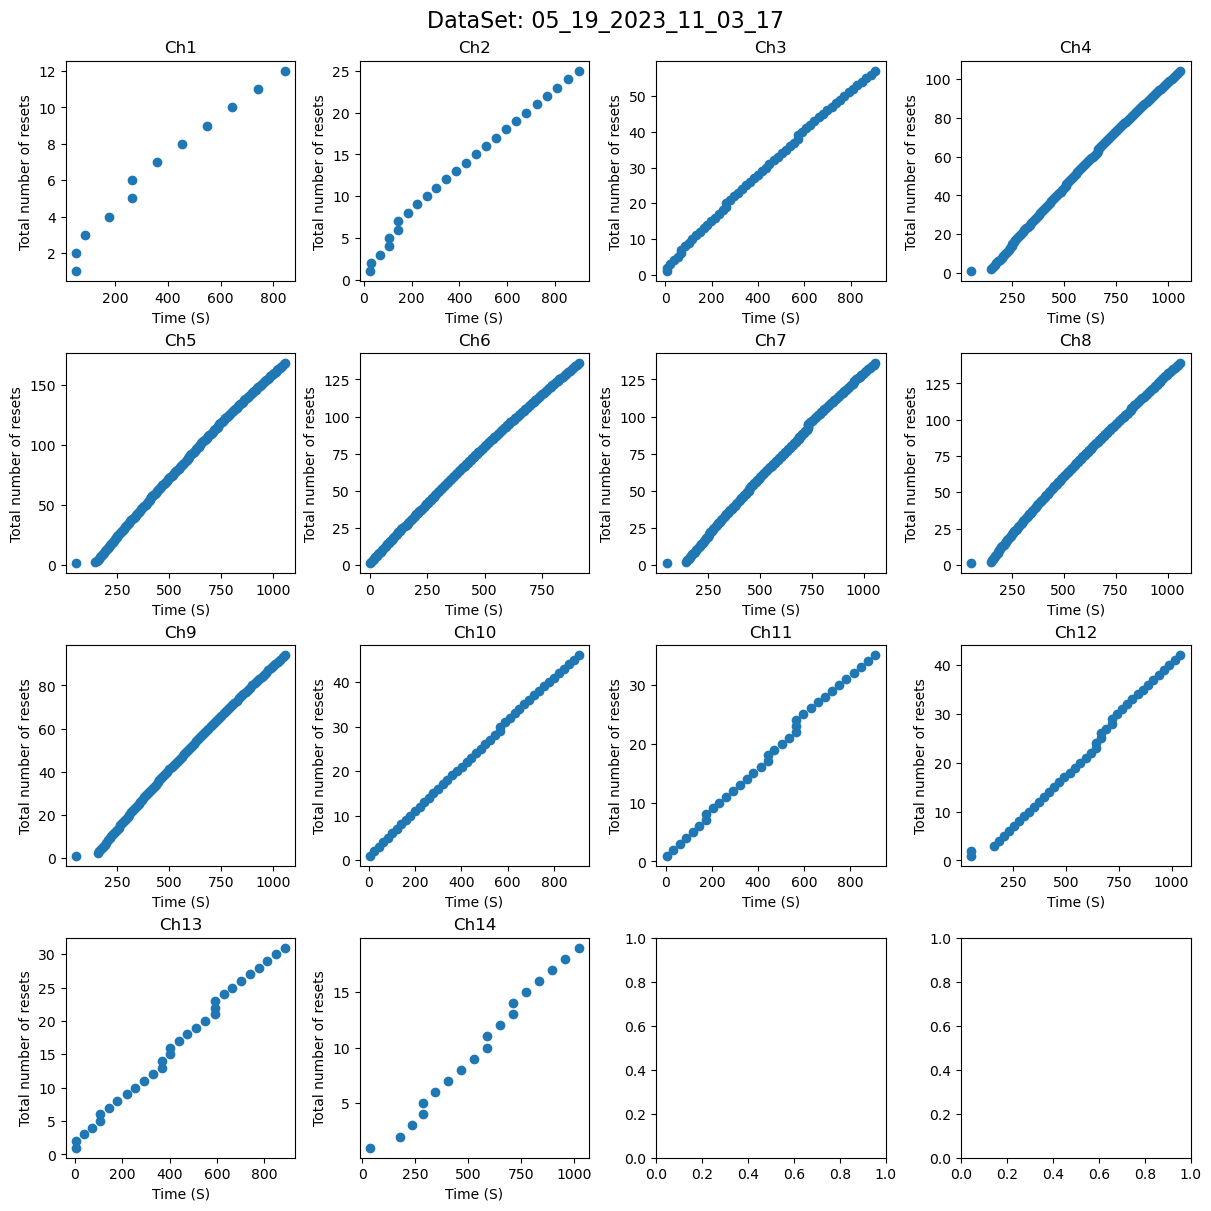

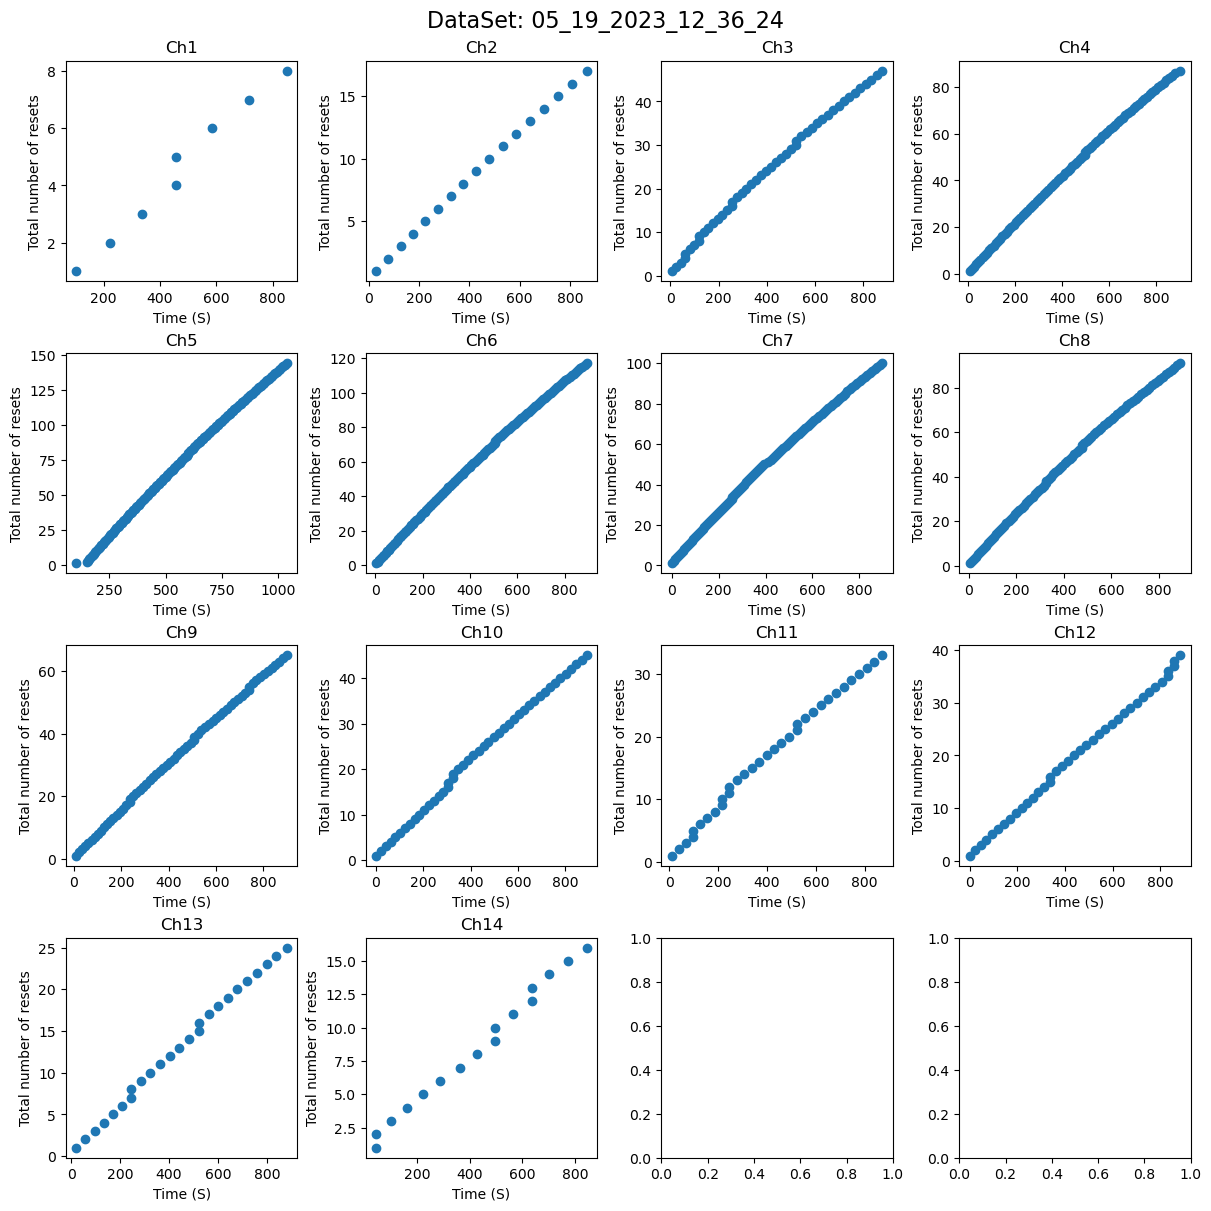

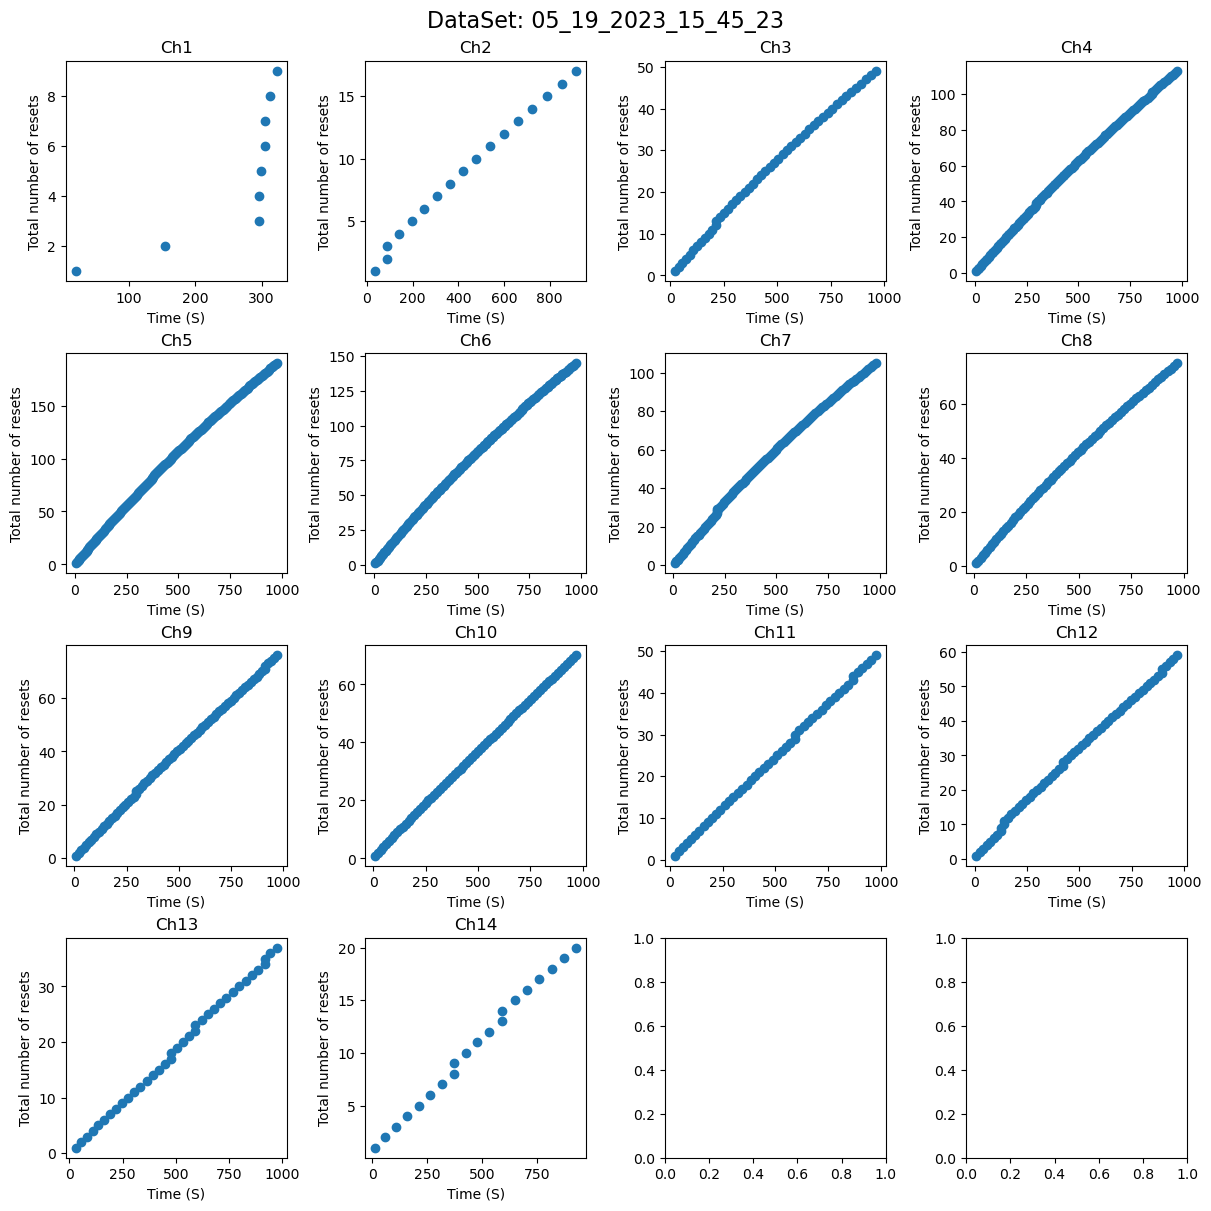

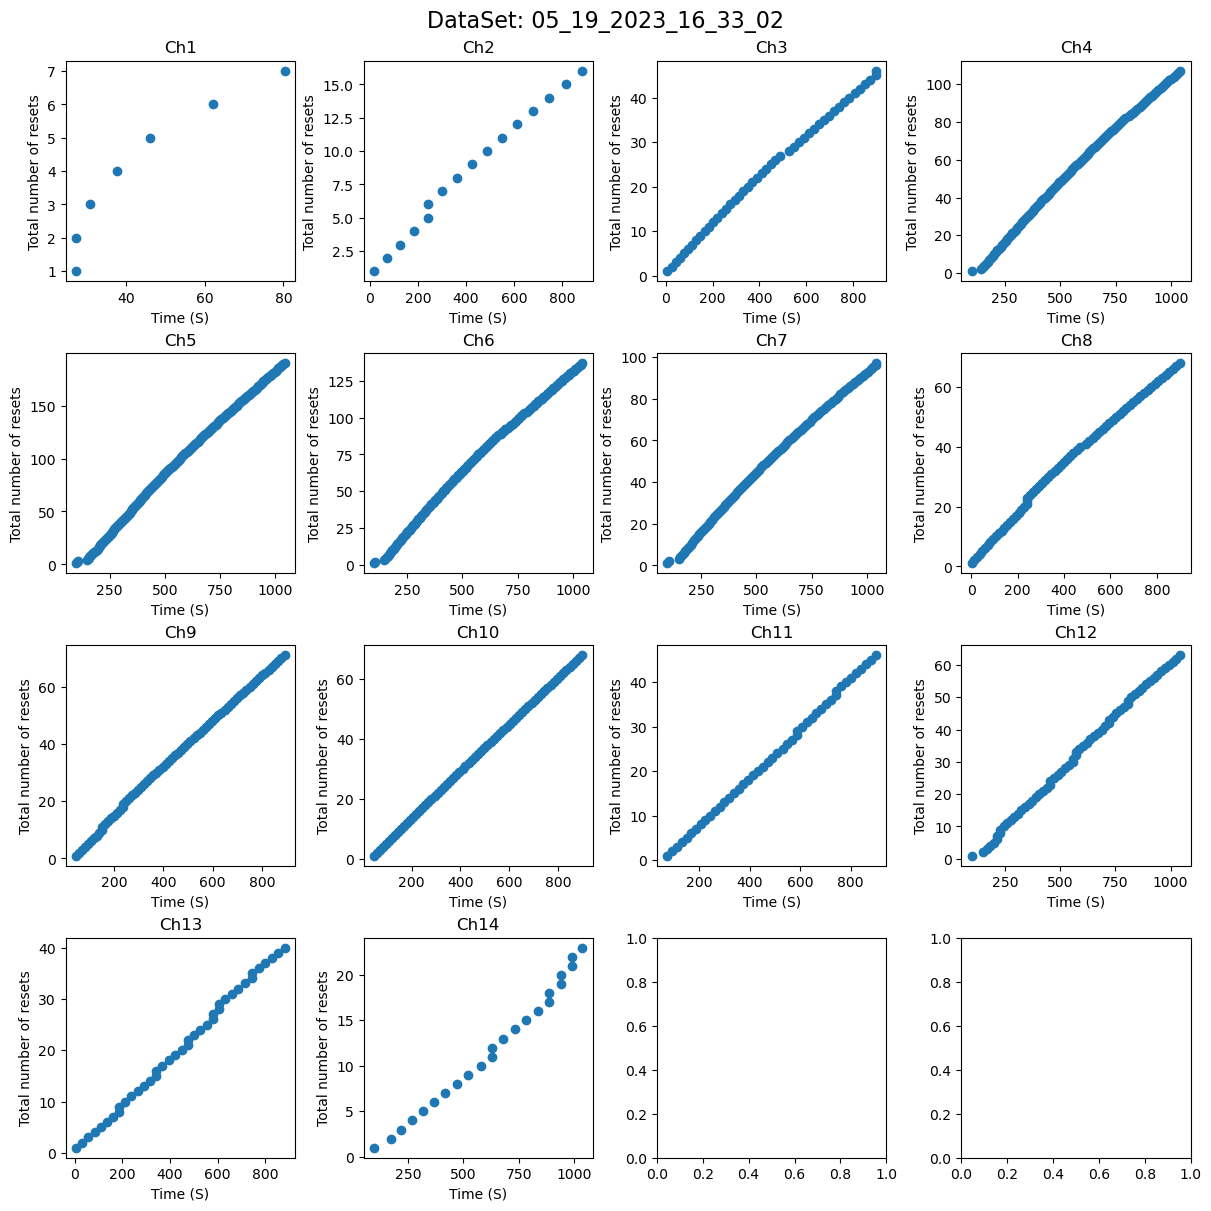

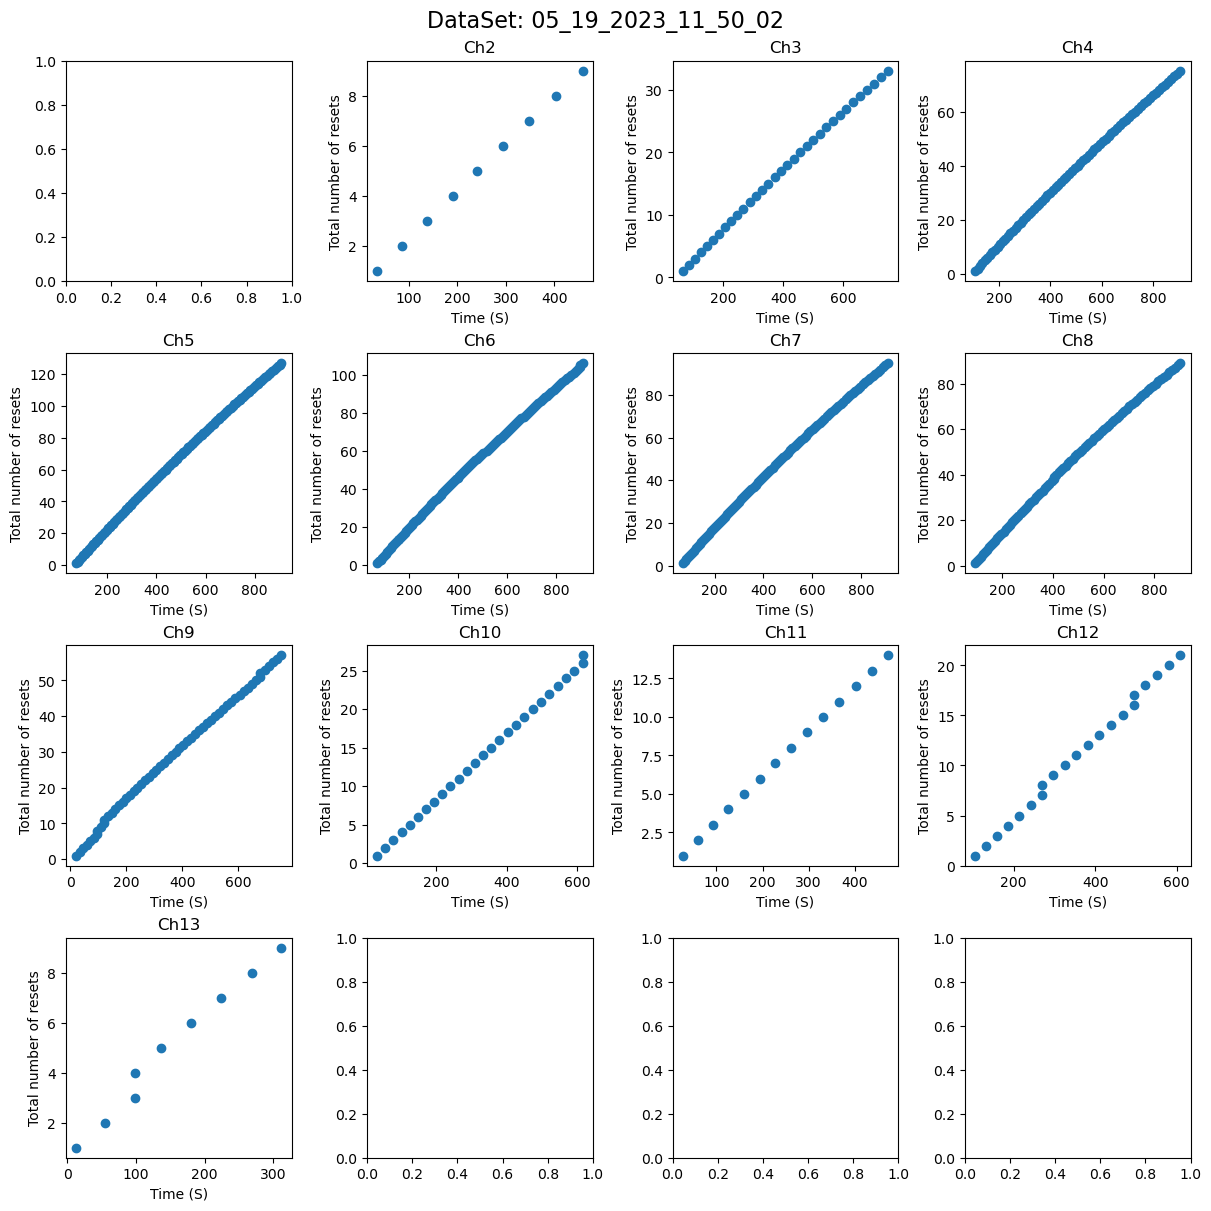

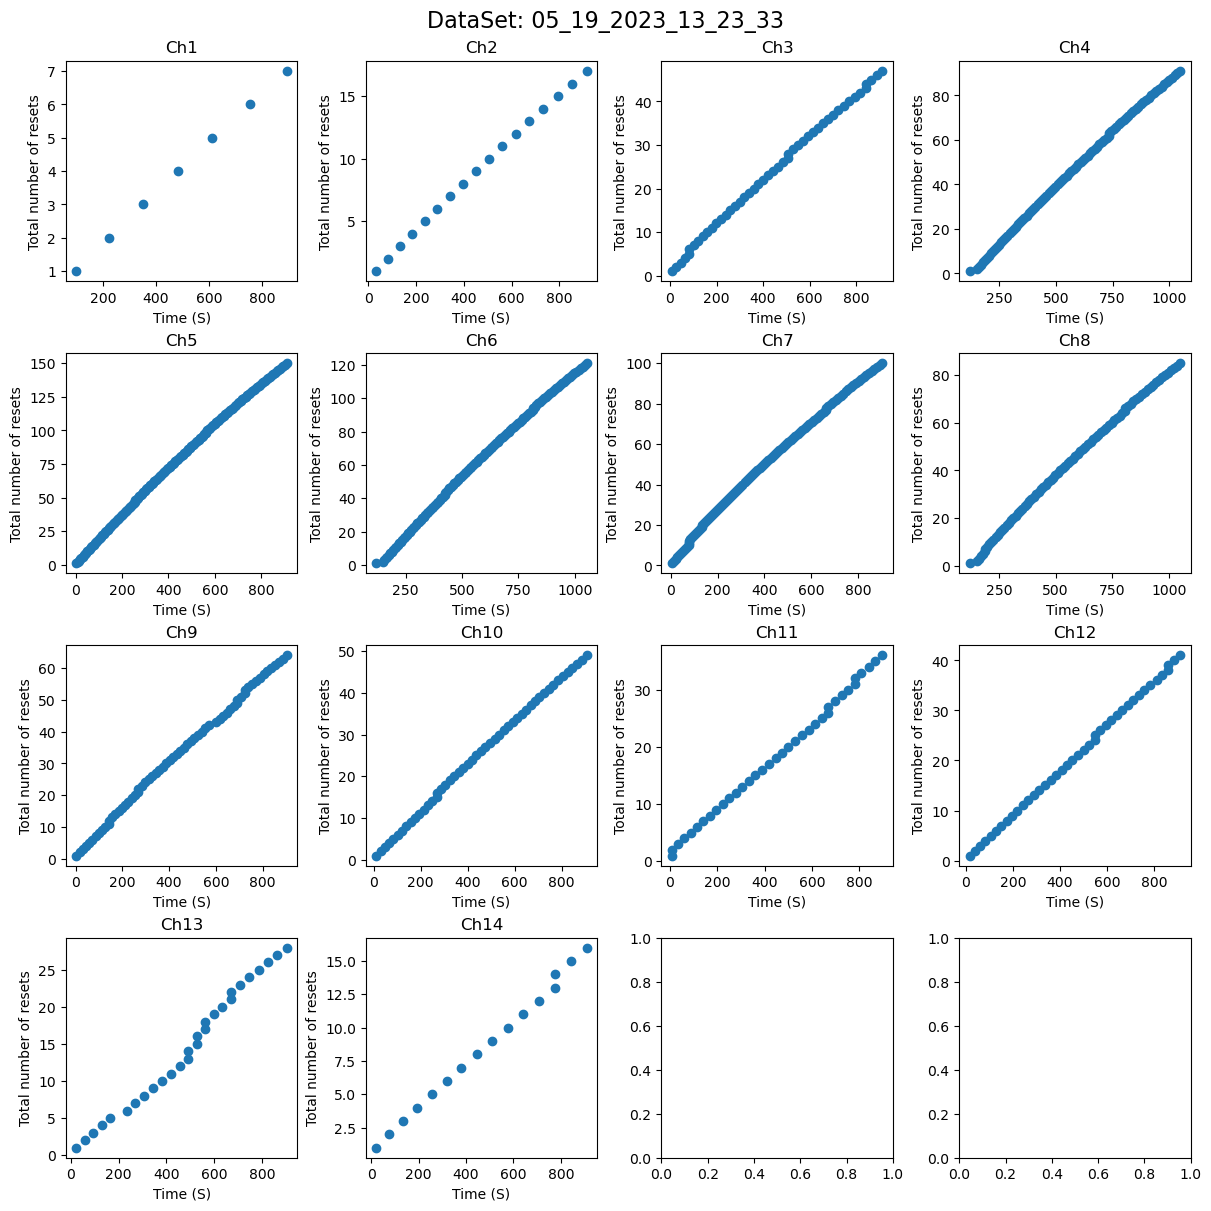

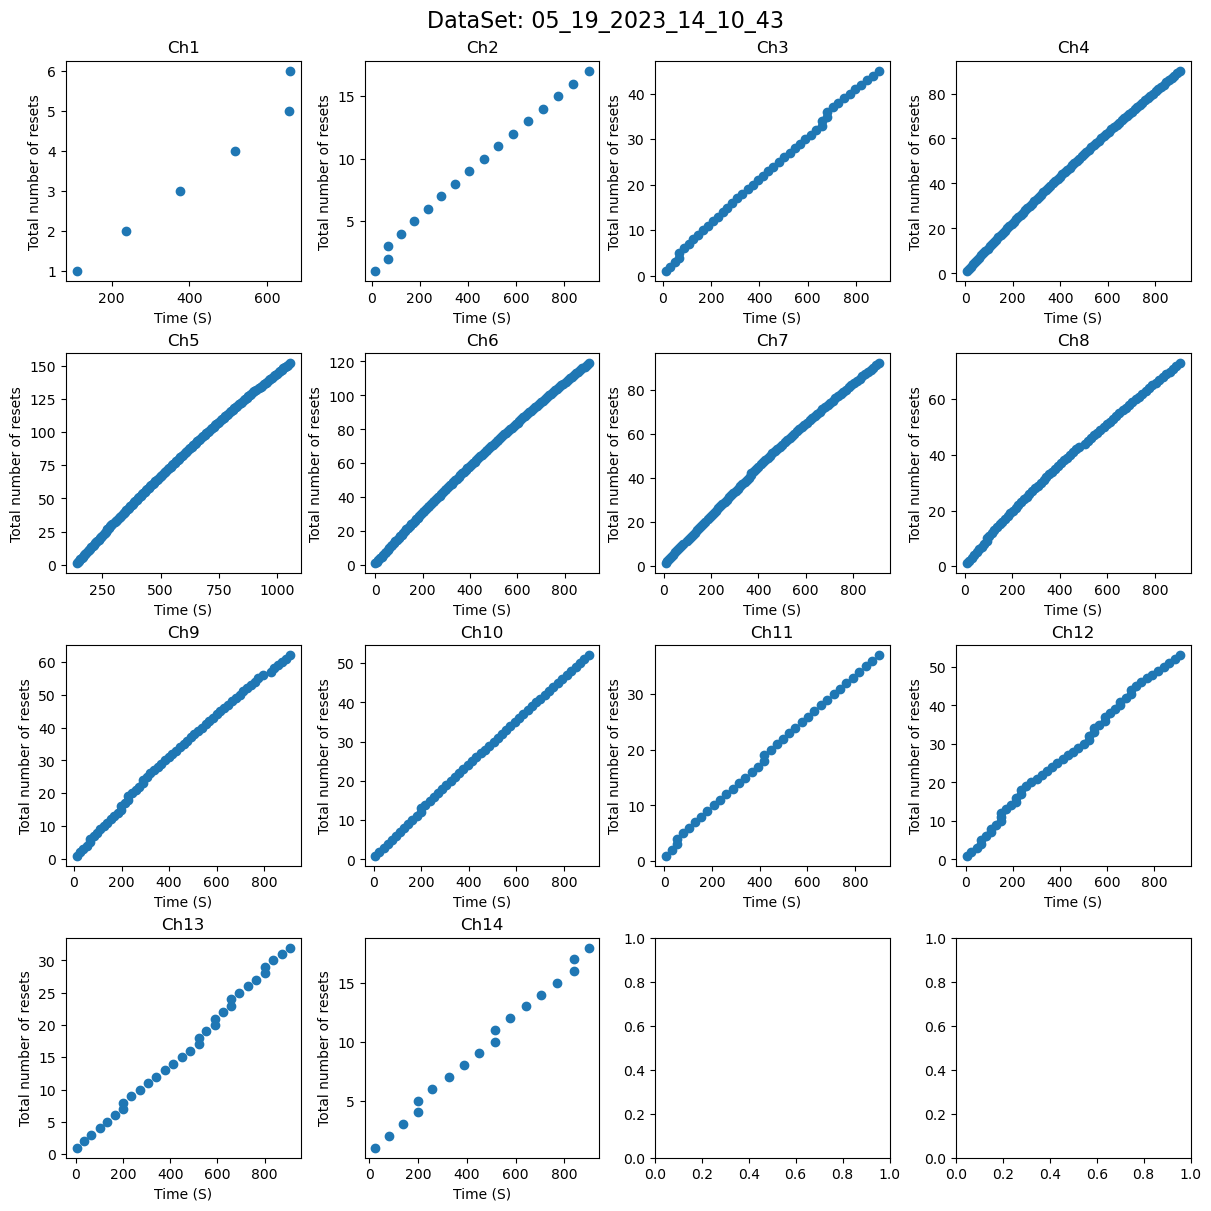

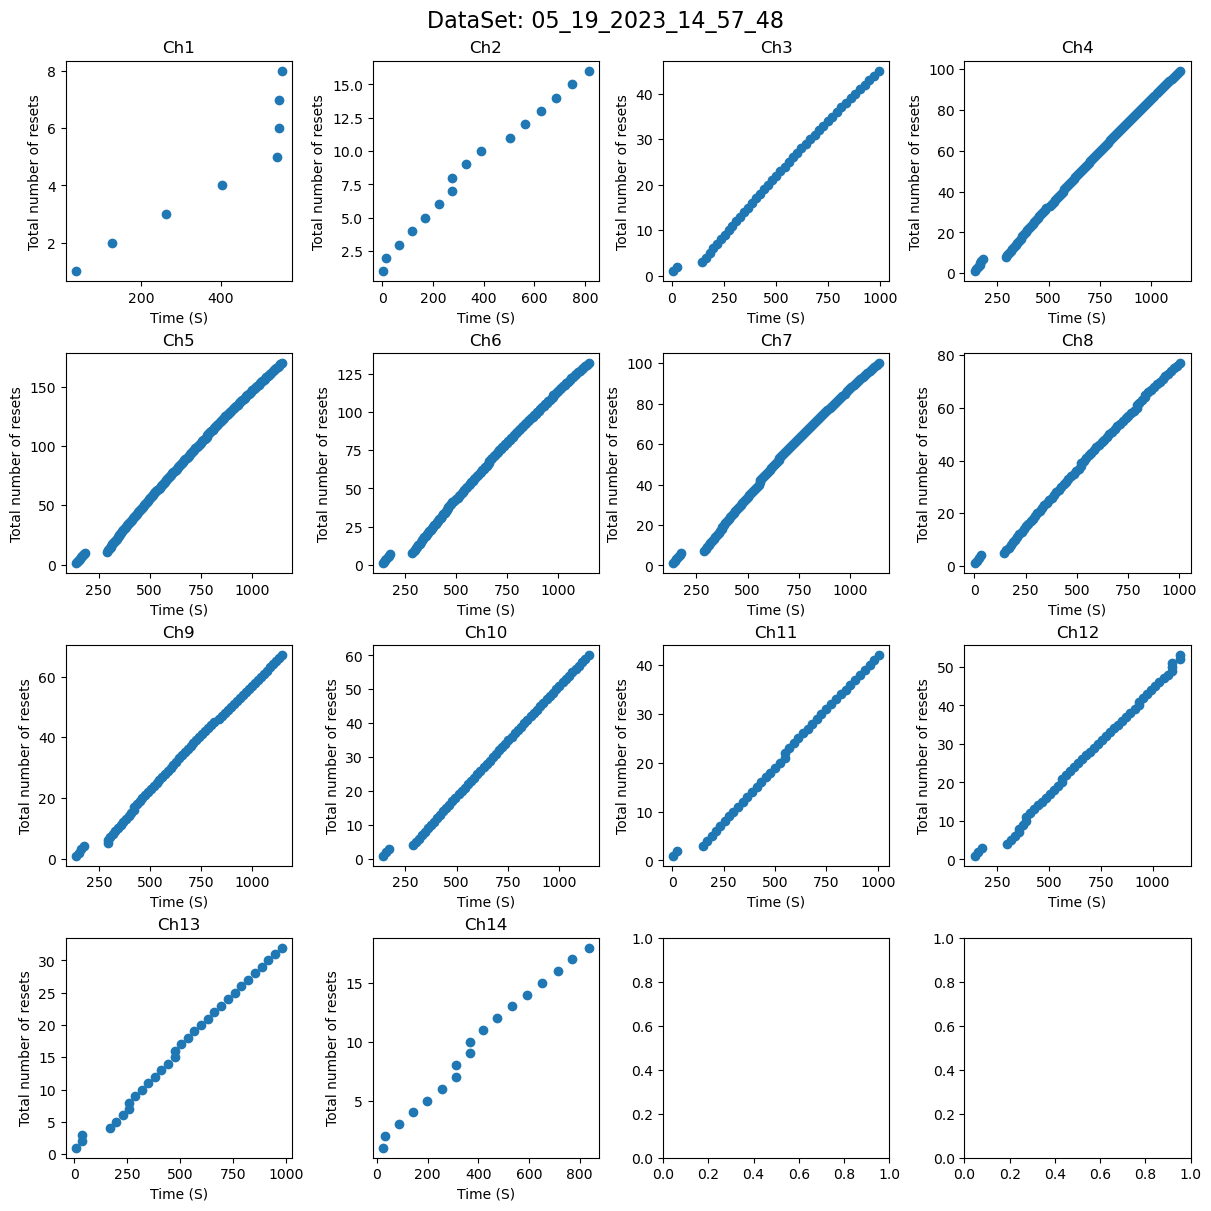

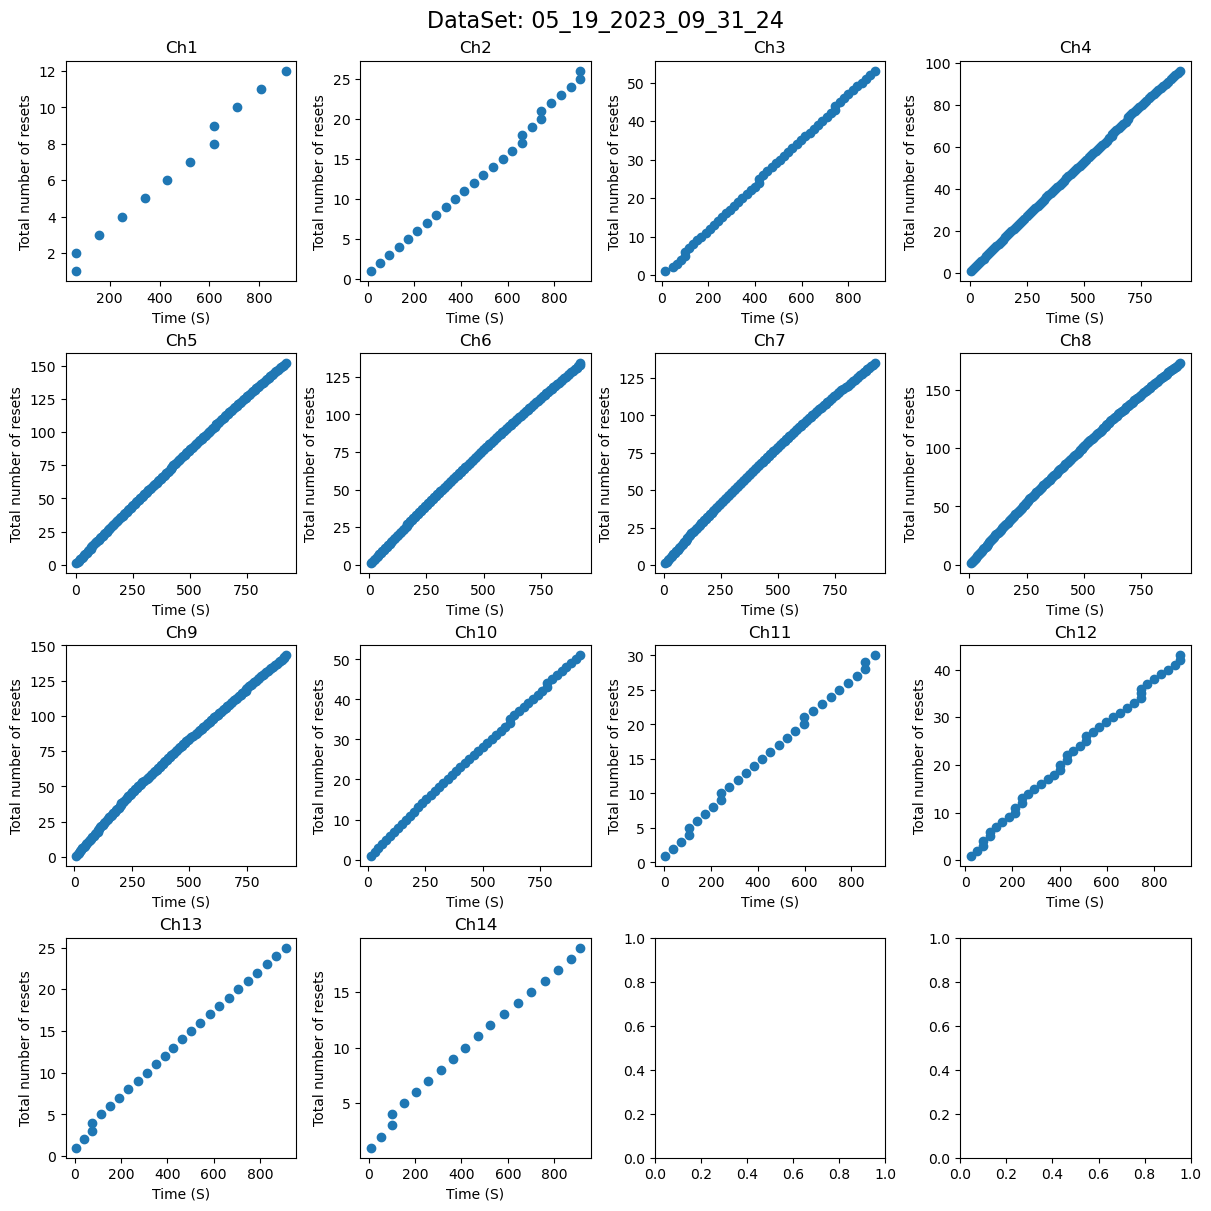

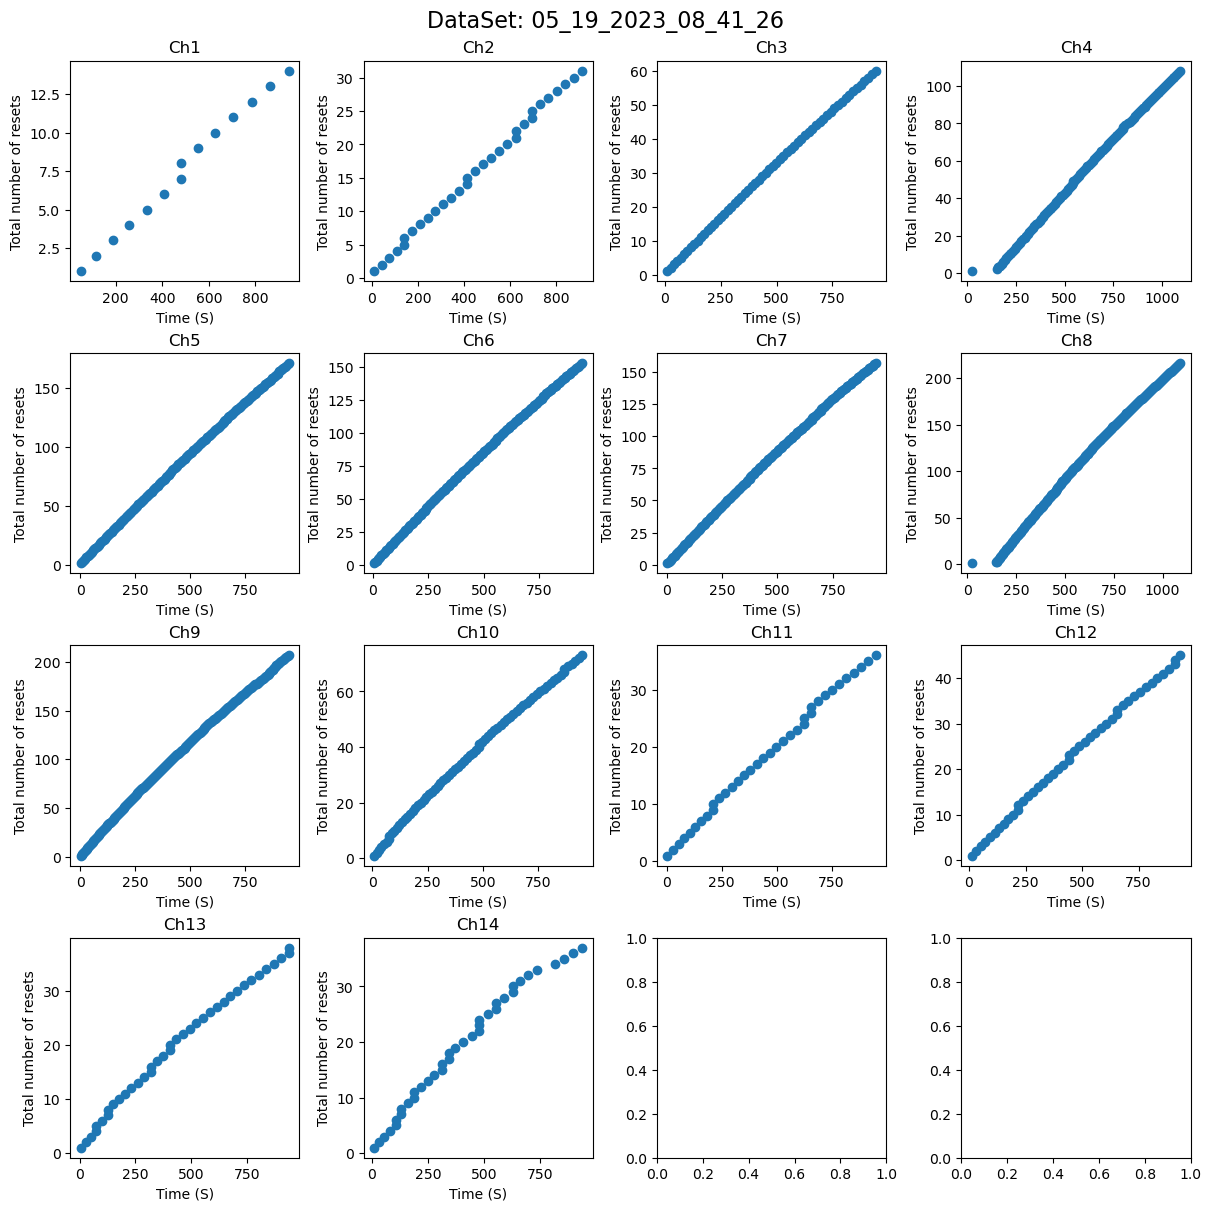

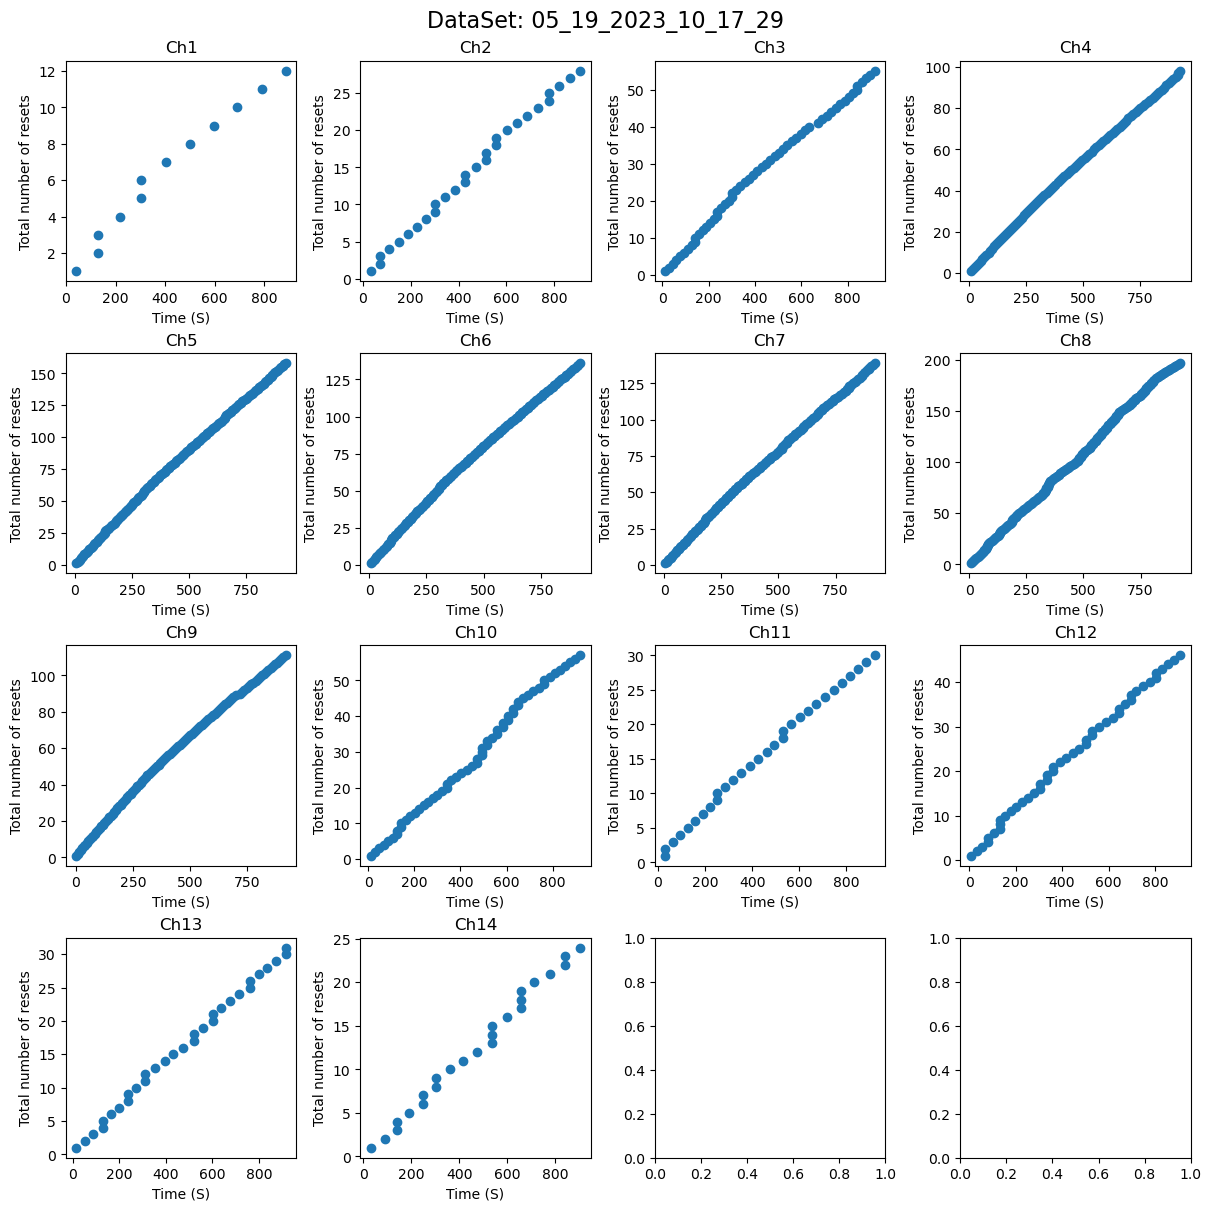

In [4]:
num=0
for value in allPressureSweeps:
    num += 1
    
    # Initialize a list to hold the 16 lists of total number of resets at each time (will be 12345...end)
    totNumResets = [[] for _ in range(16)]
    for n in range(0, len(totNumResets)):
        totalResetNum= len(value[n])
        totResetsNow = 0
        for num2 in range (0, totalResetNum):
            totResetsNow +=1
            totNumResets[n].append(totResetsNow)
            
    # Define the number of rows and columns for subplots
    num_rows, num_cols = 4, 4

    # Create the subplots with tight layout
    fig2, axs2 = plt.subplots(num_rows, num_cols, figsize=(12, 12), constrained_layout=True)

    # Flatten the axs array for easier iteration
    axs2 = axs2.ravel()

    # Loop through your data
    for i in range(0, len(value)):
        # Check if there is more than one reset data point to avoid division by 0 error
        if len(value[i]) > 1:
            axs2[i].scatter(value[i], totNumResets[i])
            axs2[i].set_xlabel("Time (S)")
            axs2[i].set_ylabel("Total number of resets")
            axs2[i].set_title("Ch{}".format(i + 1))

    fig2.suptitle('DataSet: '+ allPressureSweepNames[num-1], fontsize=16)
    fig2.savefig(input_file.split('Code')[0] + 'Code/Plots/ResetsVsTime/' + allPressureSweepNames[num-1] + '.png')


## 3. Get the Reset Time differences and plot:

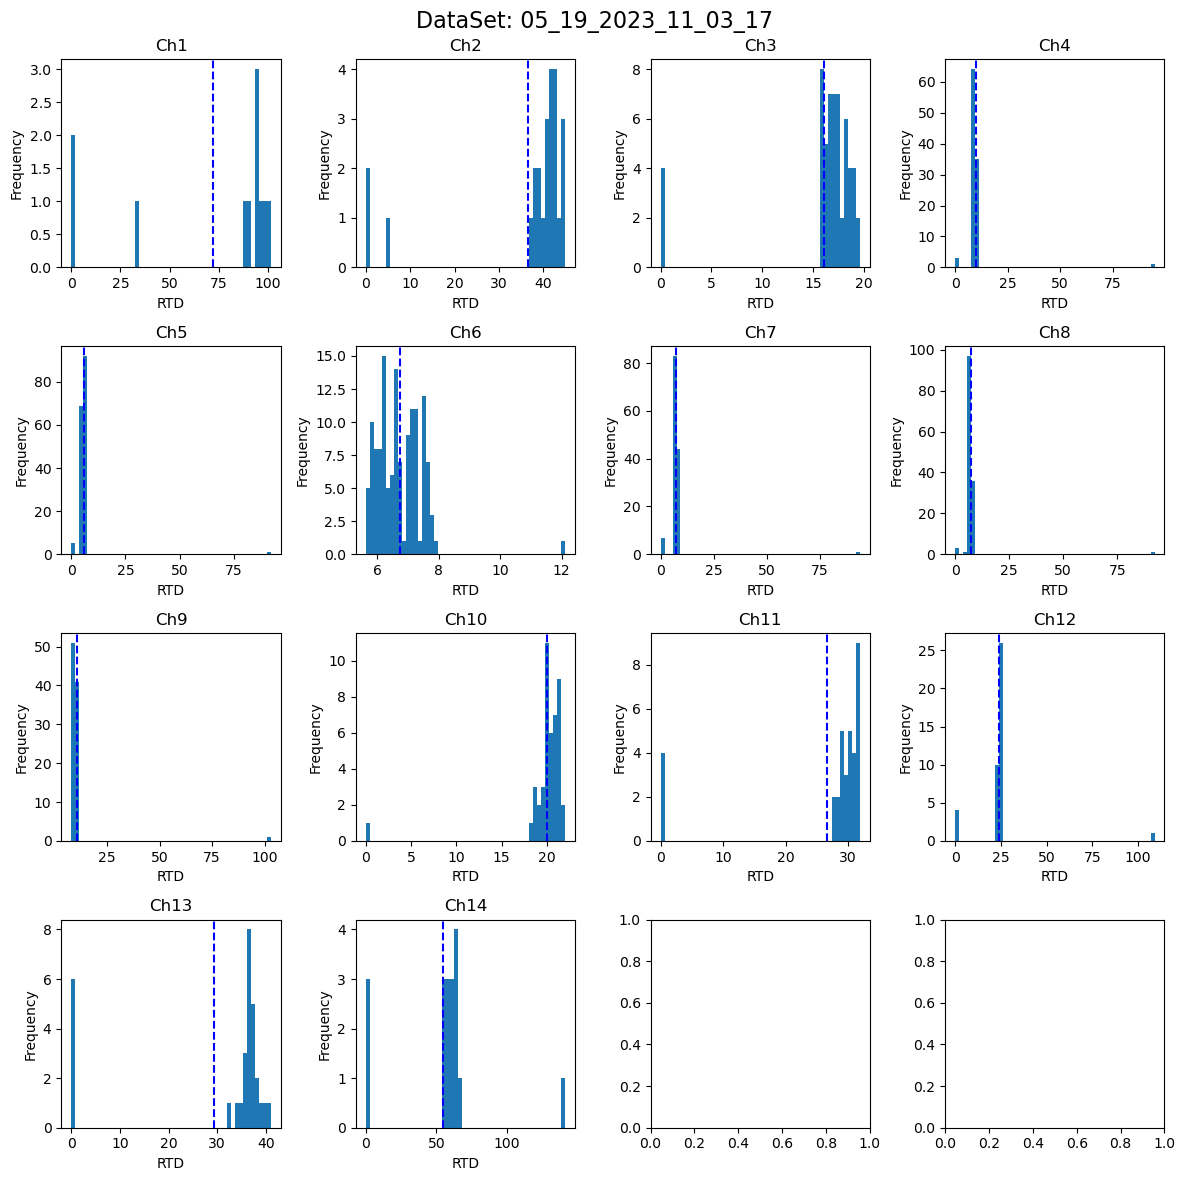

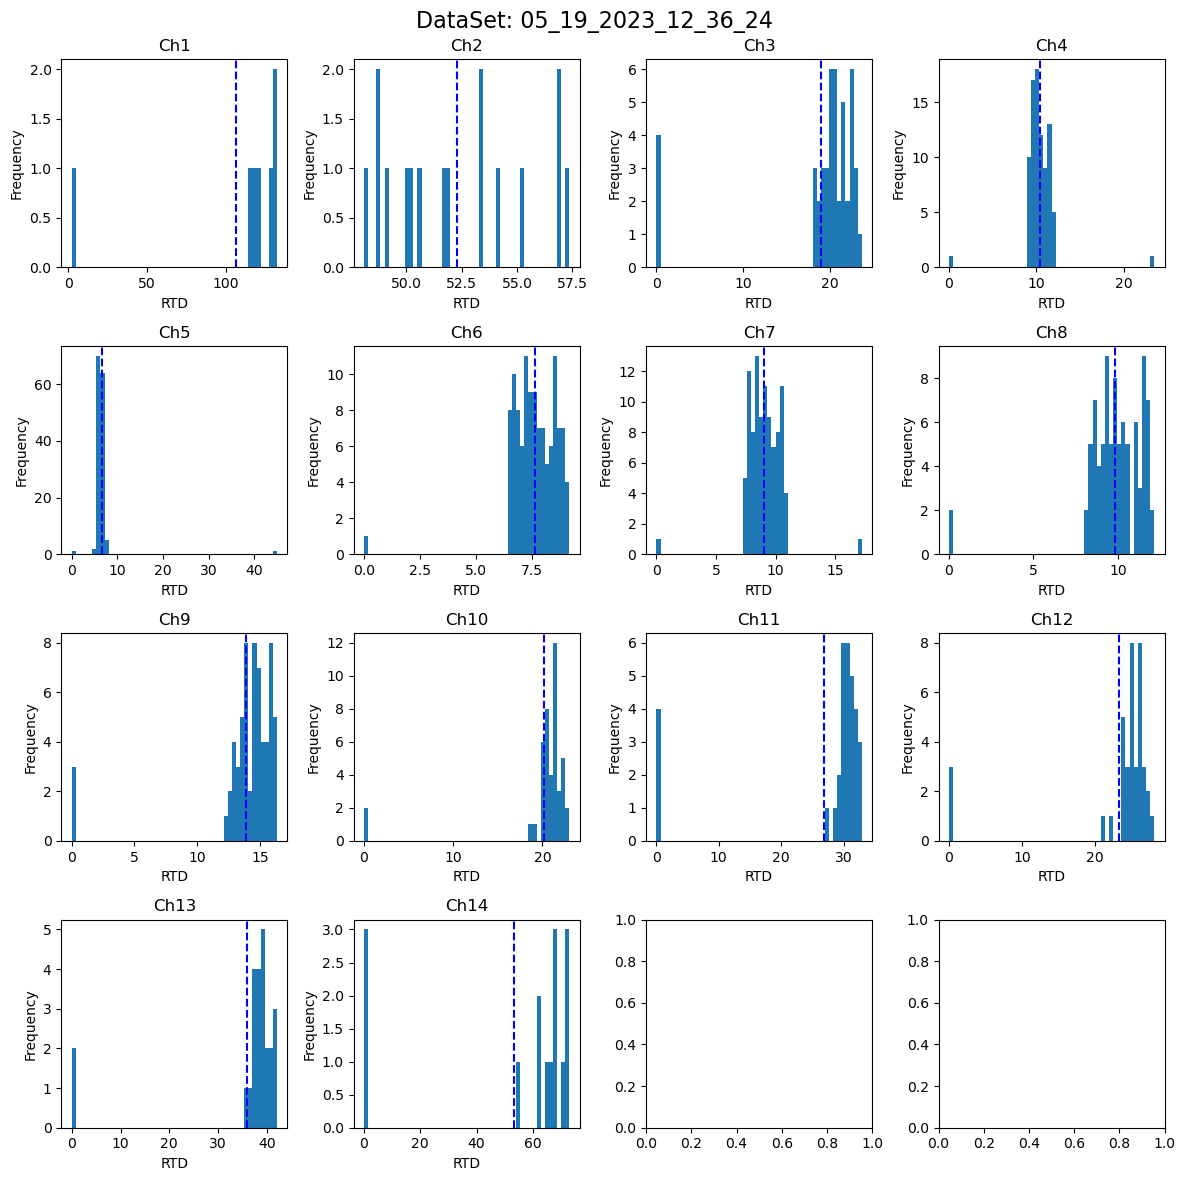

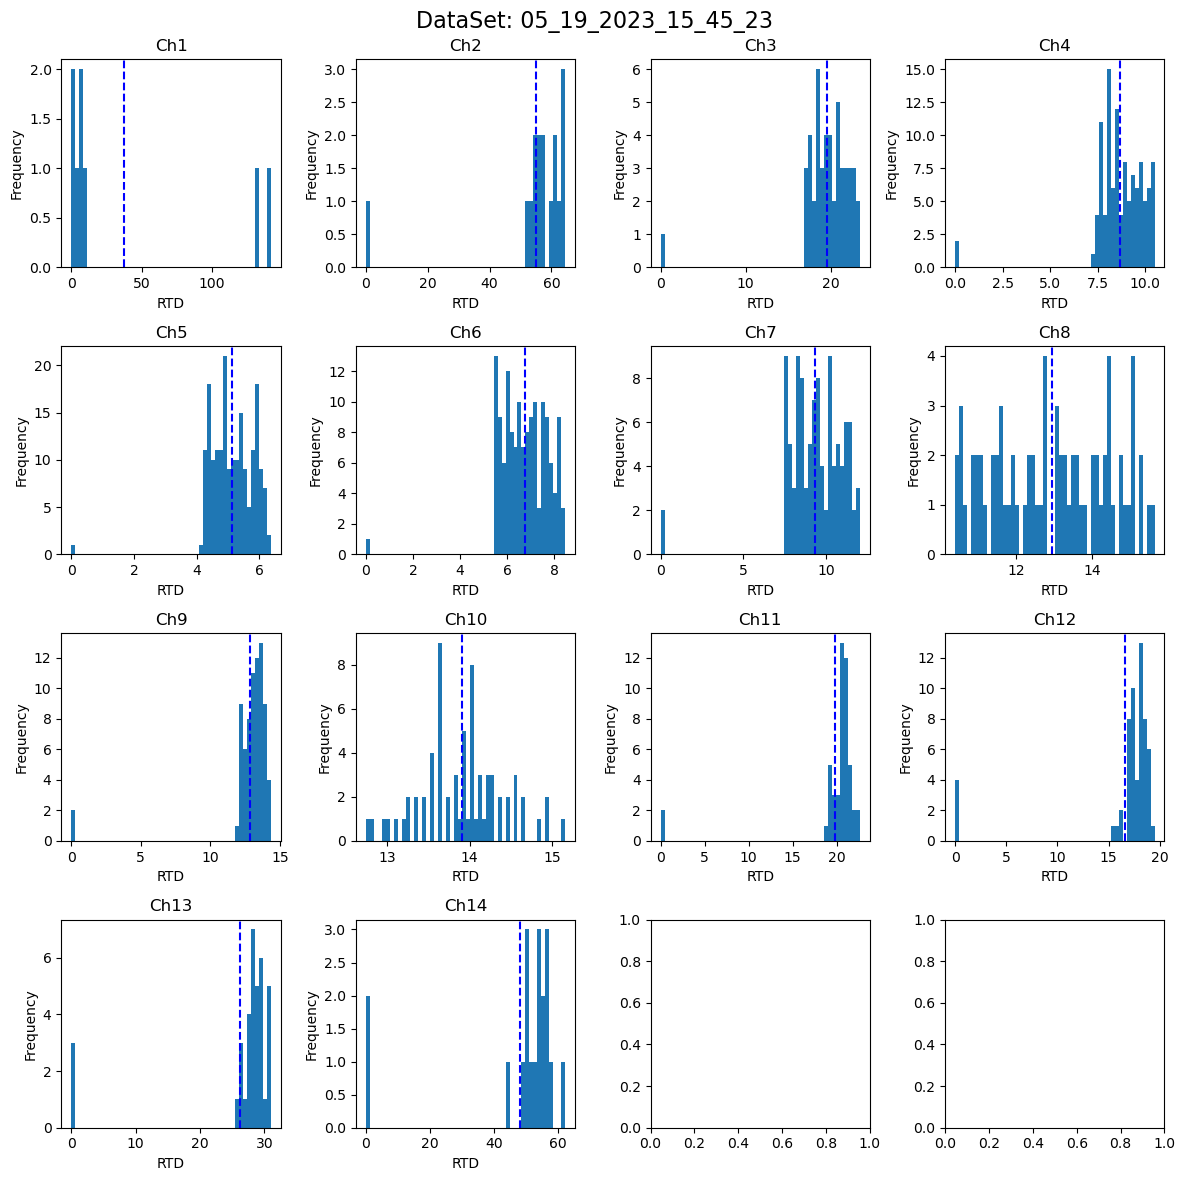

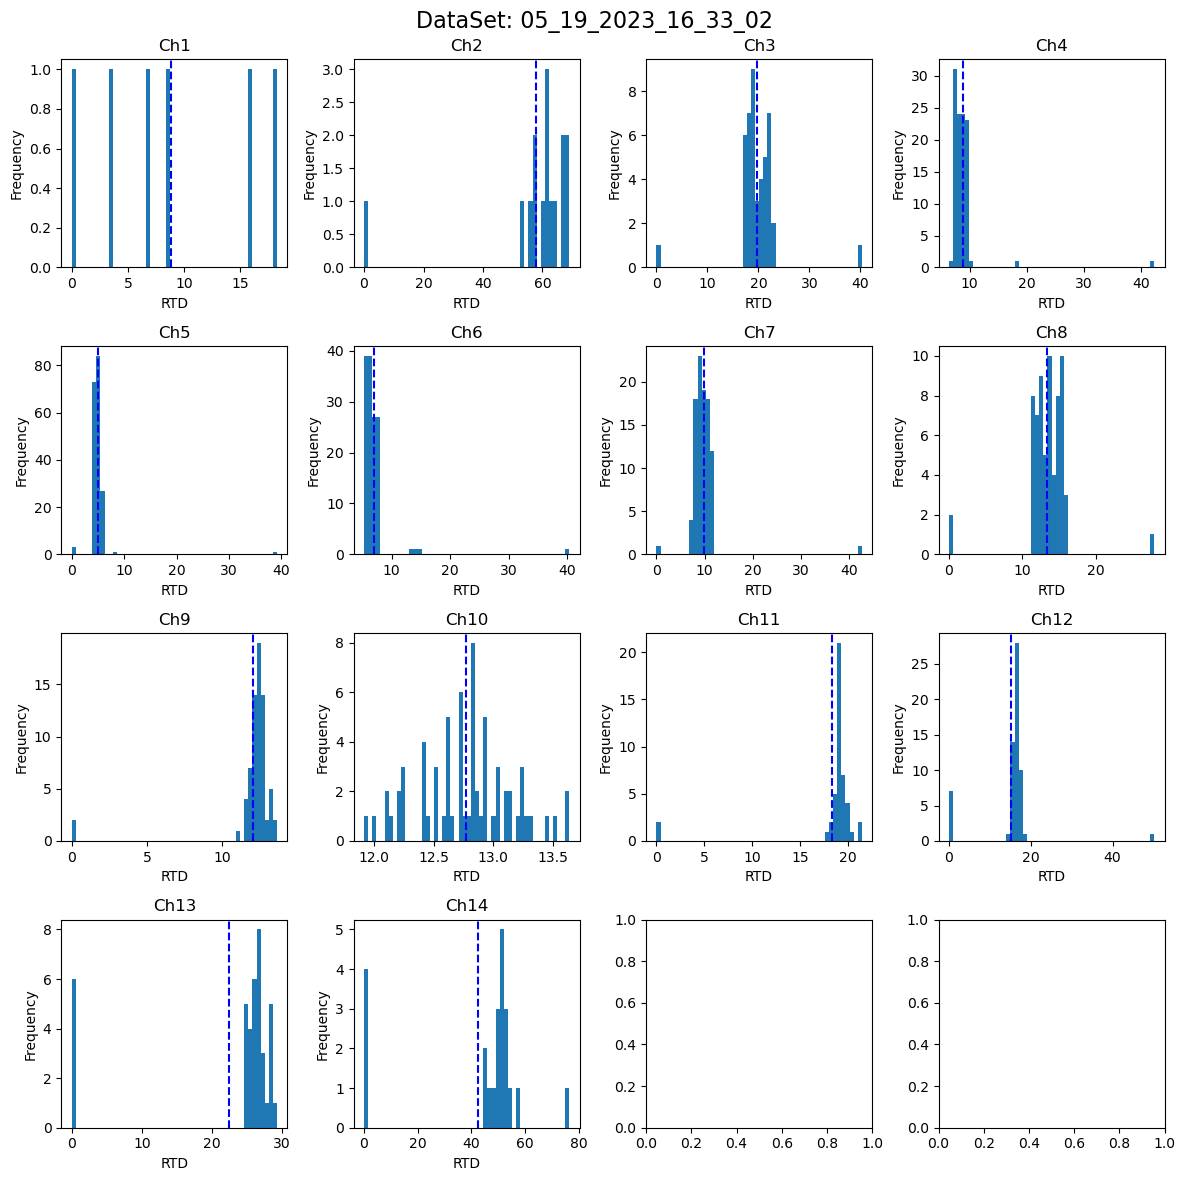

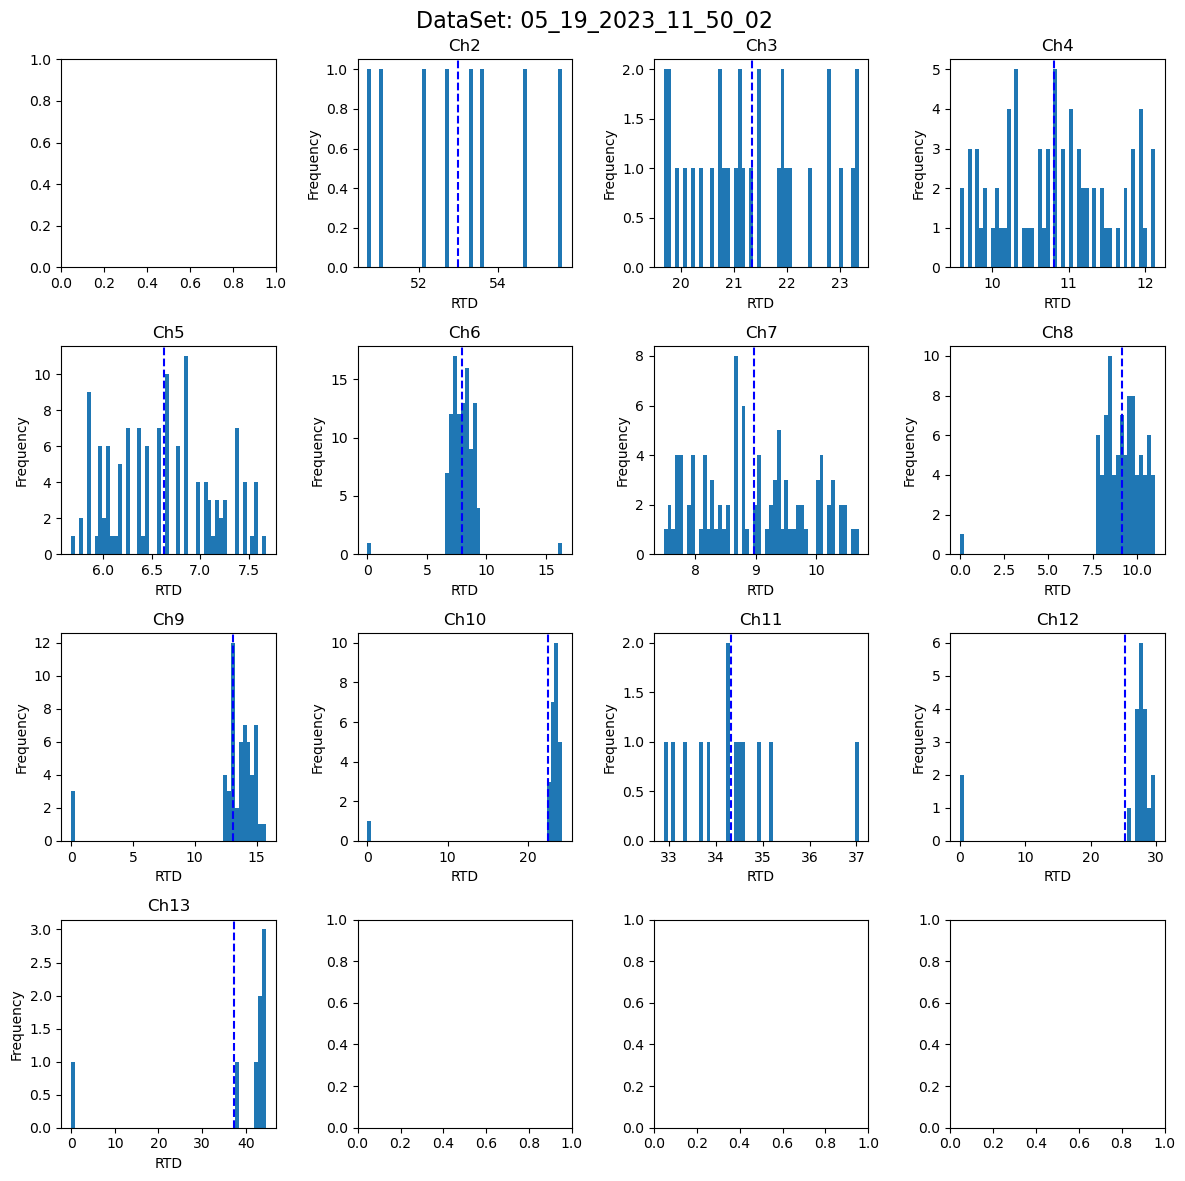

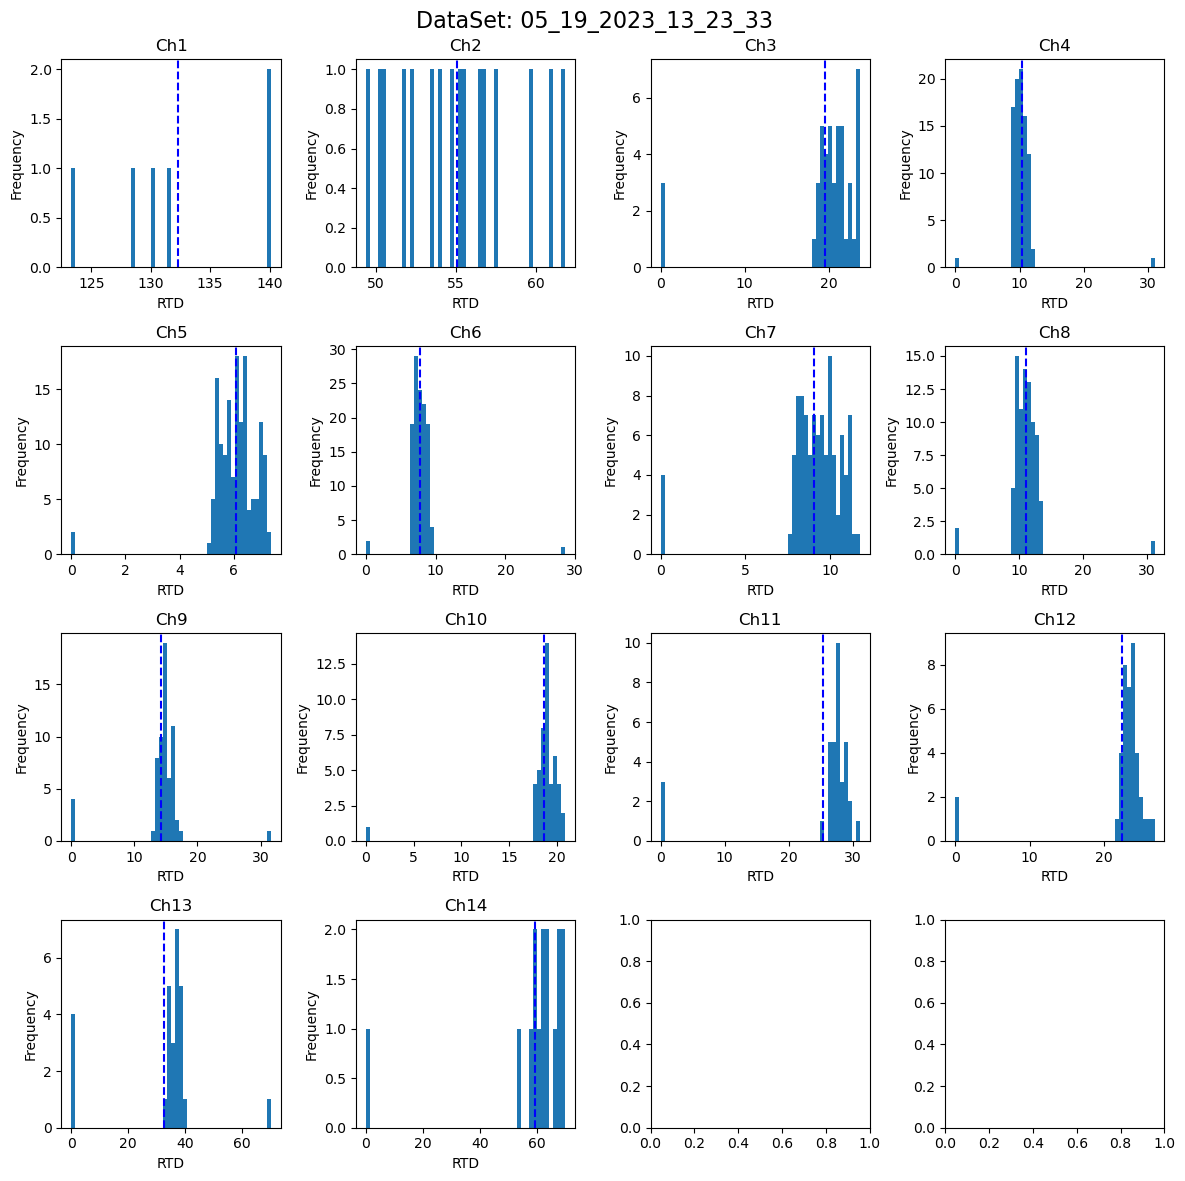

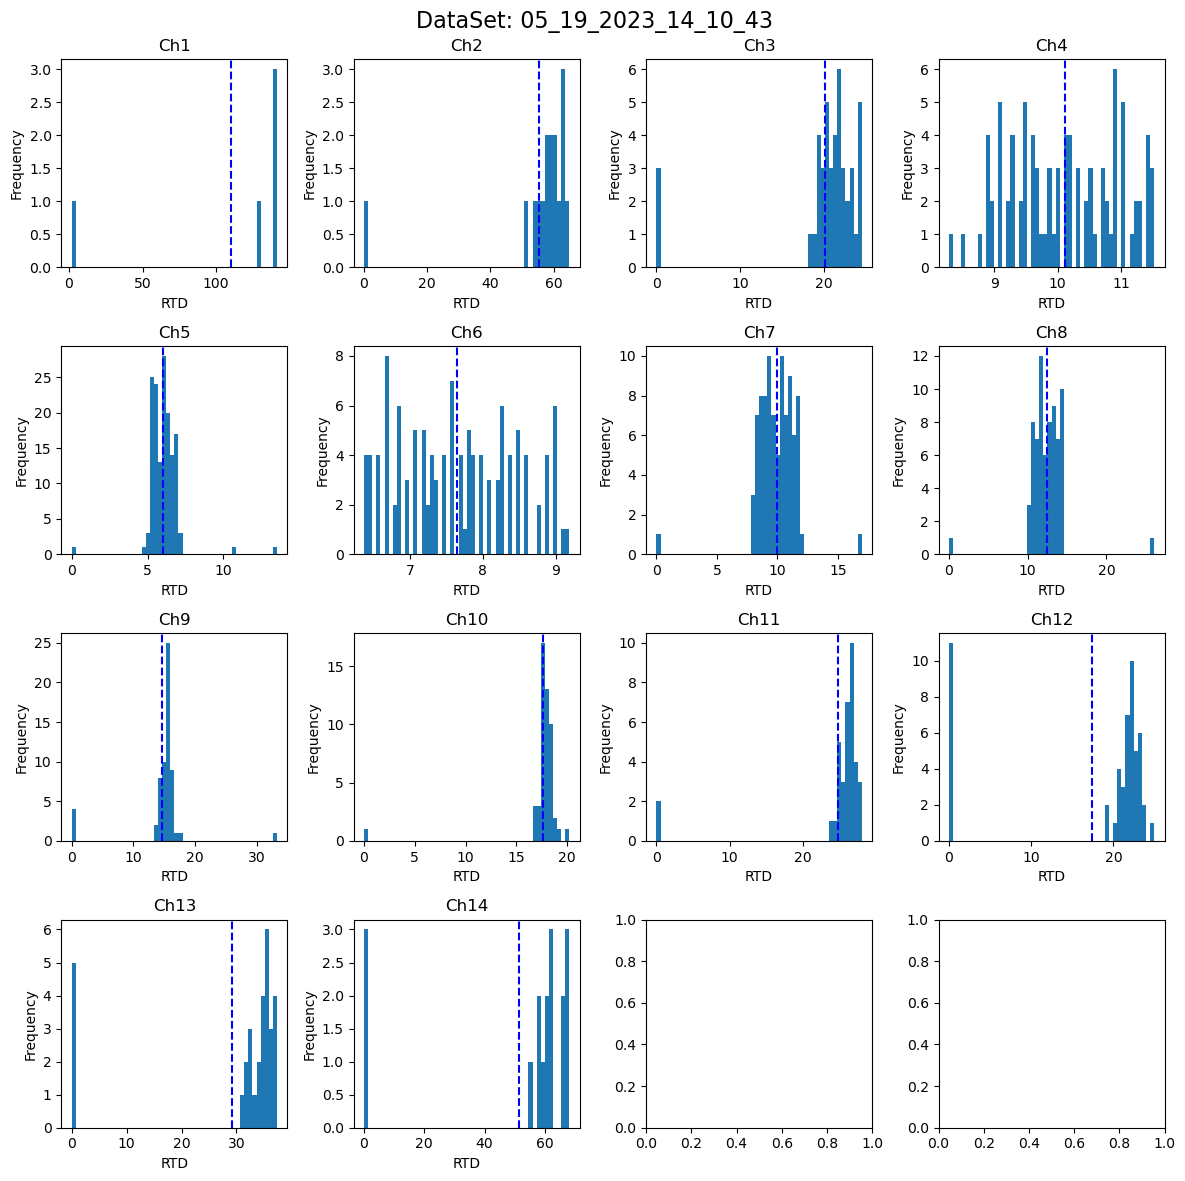

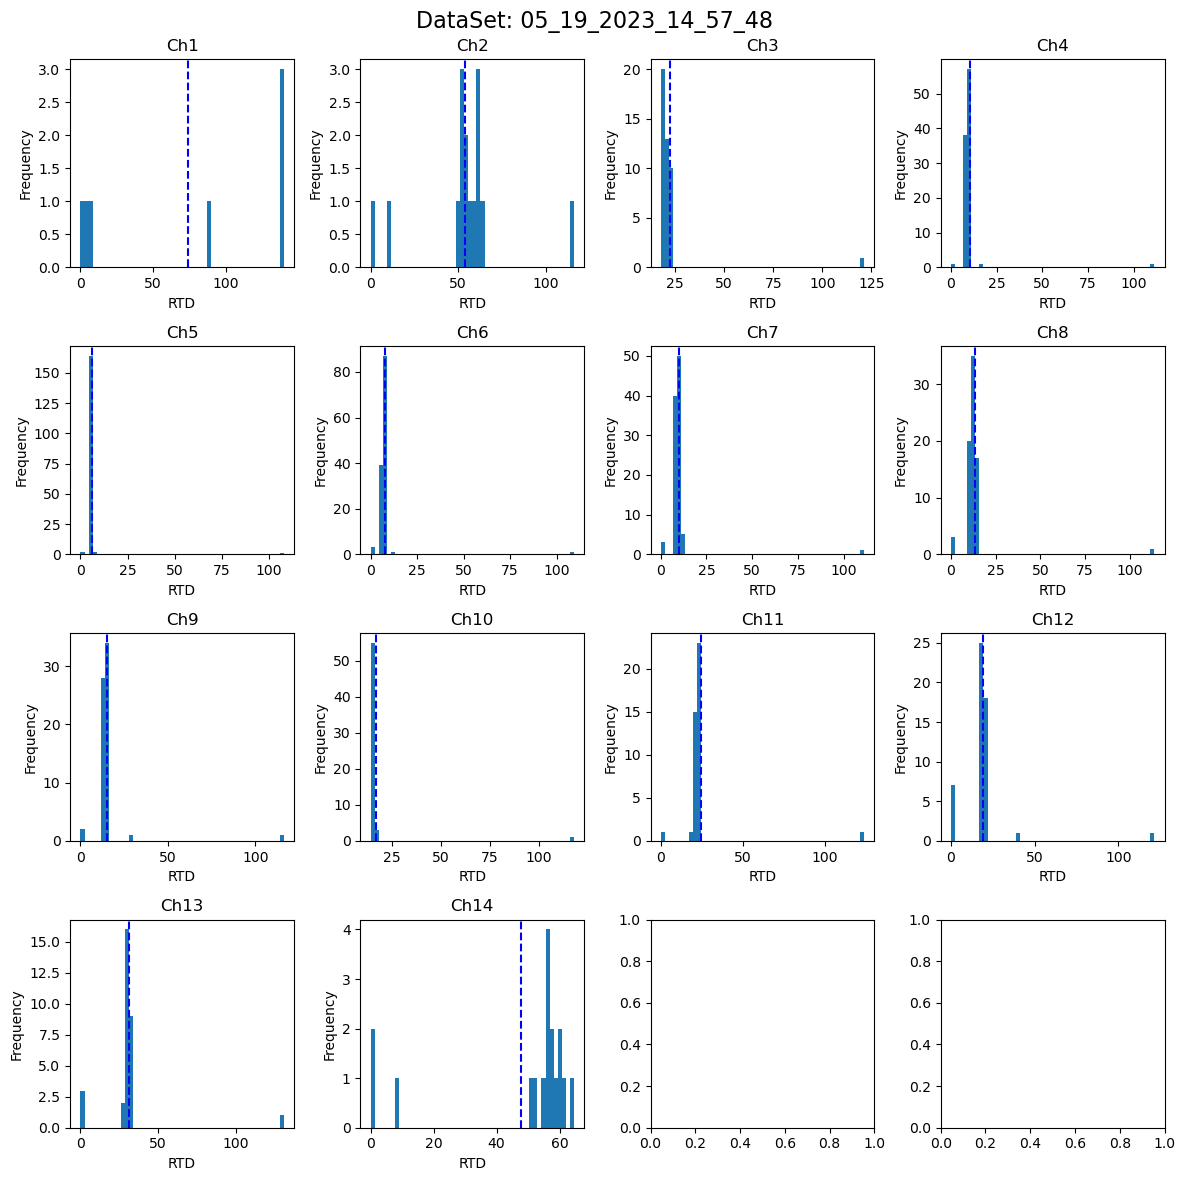

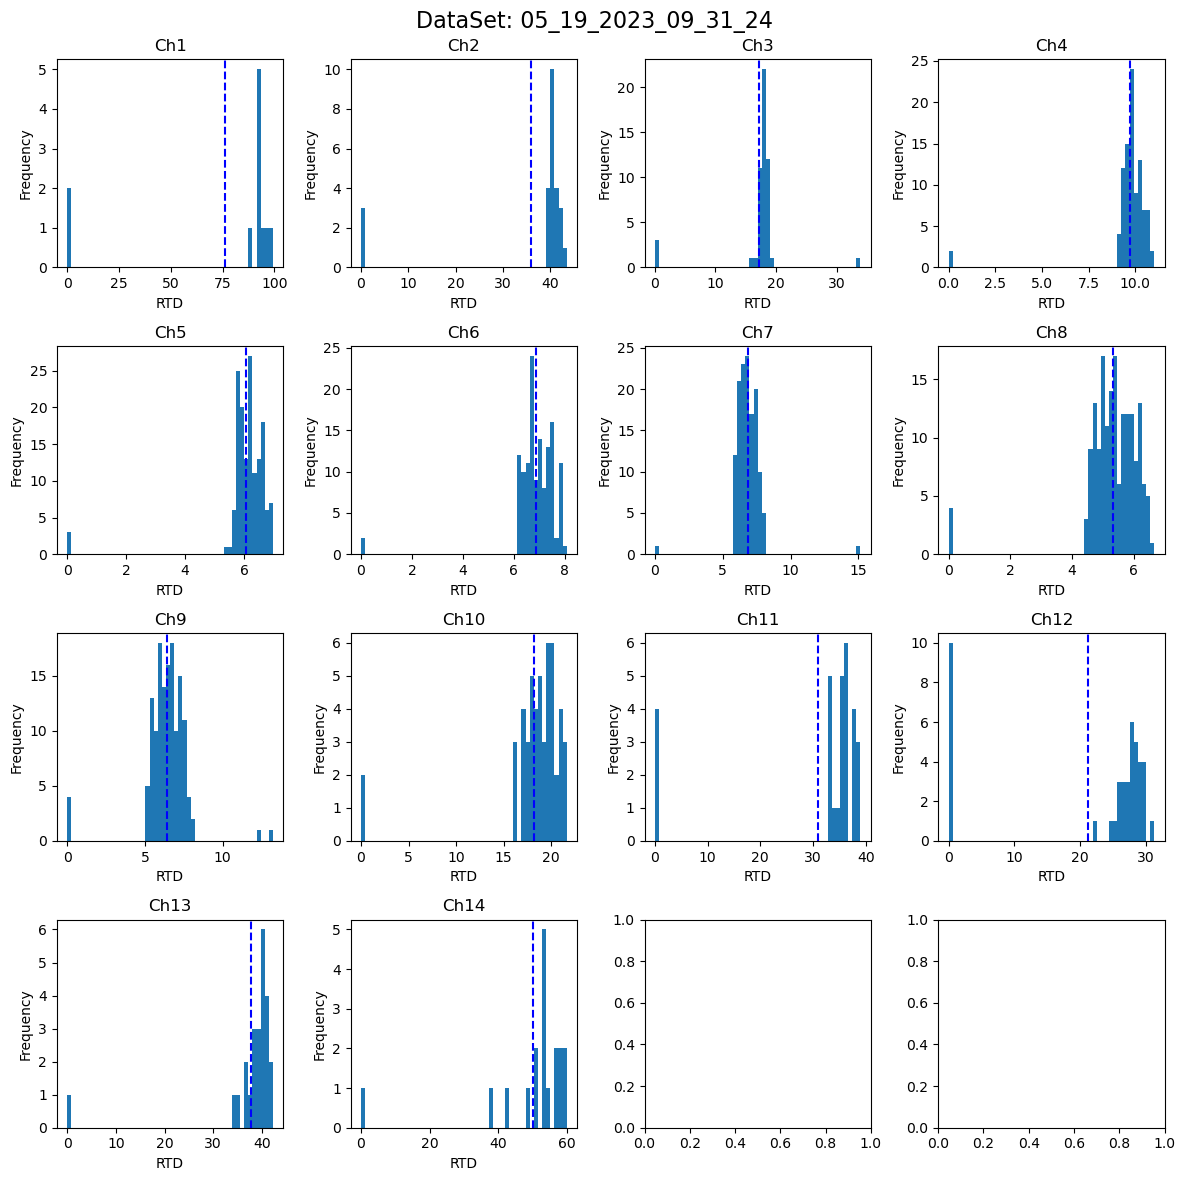

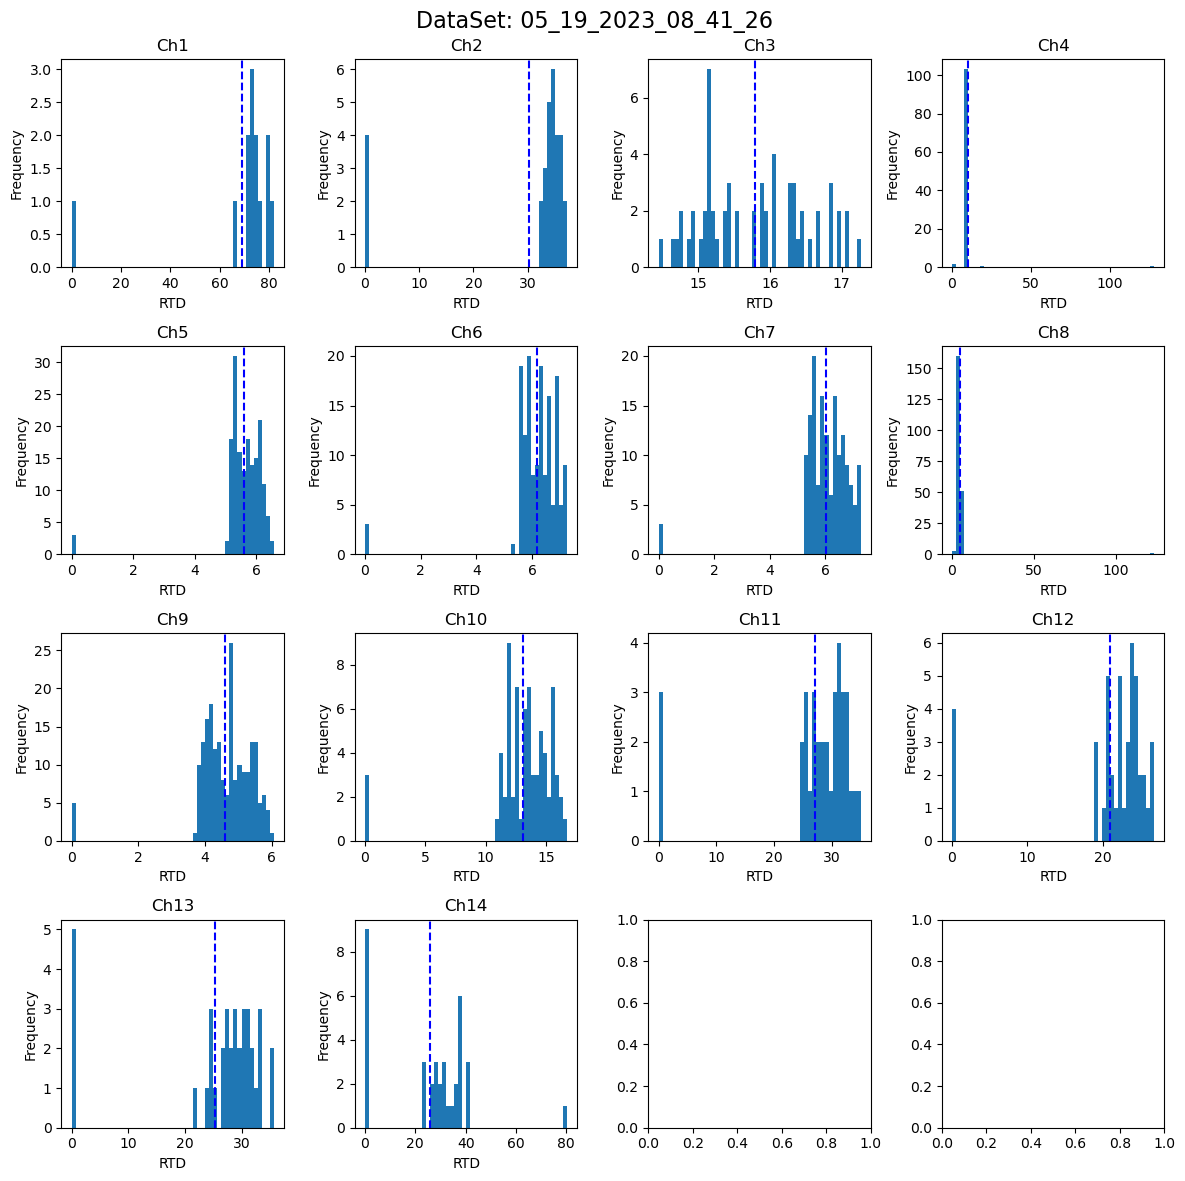

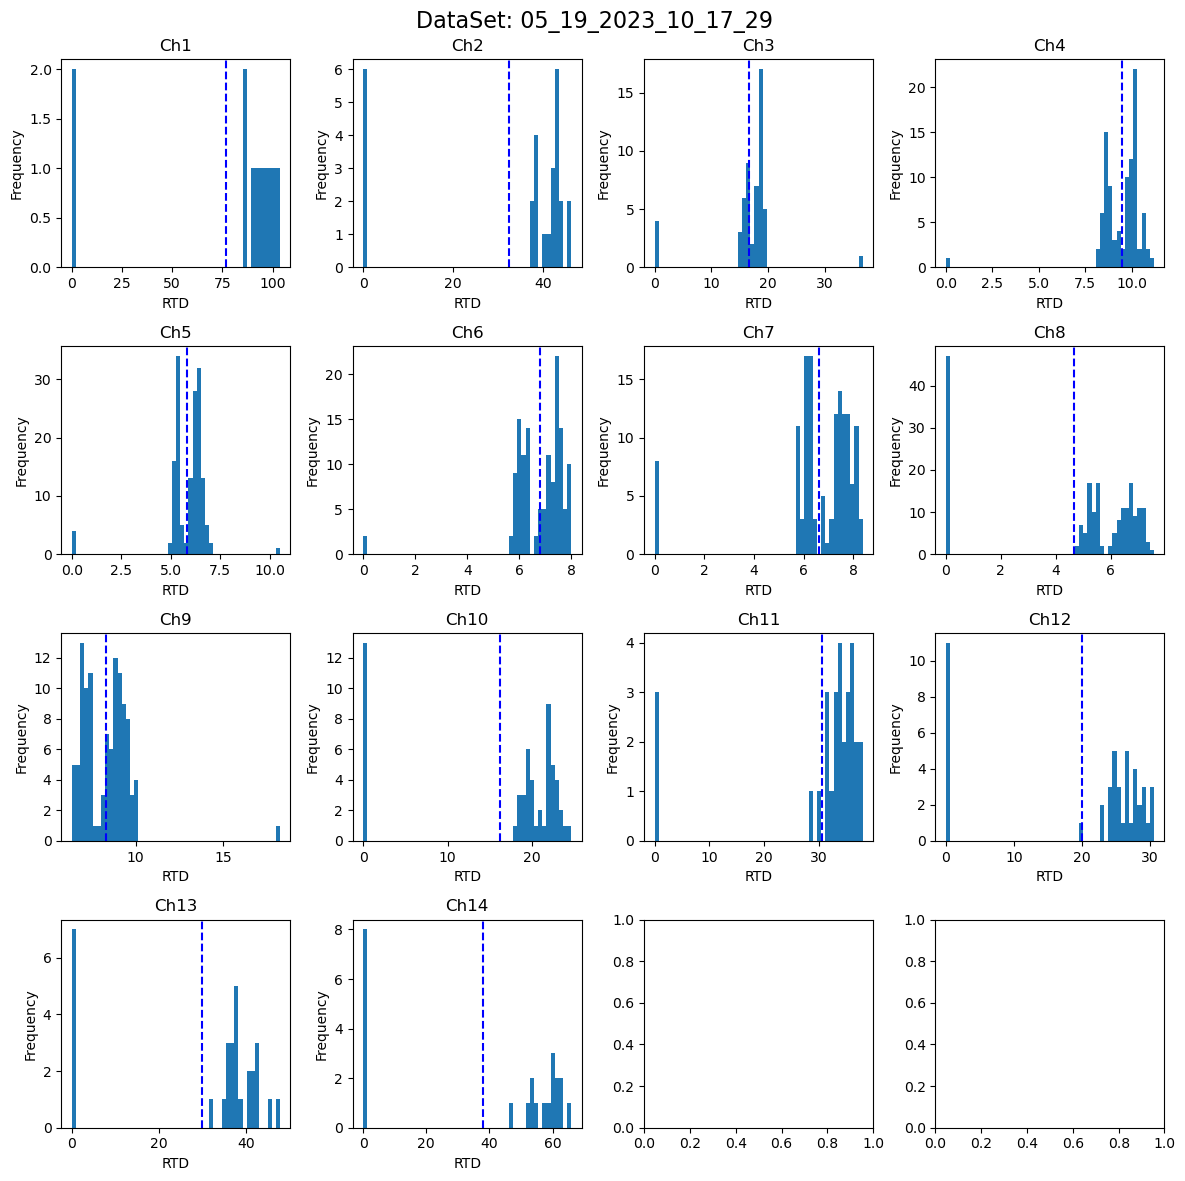

In [5]:
eachCurrentRTDHolder=[]


# Go through each individual input current value and do analysis
#value is a 14 index list
num=0
for value in allPressureSweeps:
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    axs = axs.ravel()
    # Initialize a list to hold the 16 lists of reset time differences for data
    reset_time_diffs = [[] for _ in range(16)]
  
    # Iterate over the elements of 'value' using enumeration
    for i, timeStamps in enumerate(value):
        
        # Check if there are rtds, if not leave the list empty as it already is
        if len(timeStamps) > 0:
            rtd_list = []
            for index in range(0,len(timeStamps)):
                if index !=0:
                    rtd = timeStamps[index]-timeStamps[index - 1]
                    rtd_list.append(rtd)
            reset_time_diffs[i] = [num for num in rtd_list]

        # Need to make this greater than one reset because otherwise there is a division by 0 error
        if len(reset_time_diffs[i]) > 1:

            meanRtd = np.mean(reset_time_diffs[i])
            axs[i].hist(reset_time_diffs[i], bins=50) # loook into this function for bins
            axs[i].axvline(meanRtd, color='blue', linestyle='--')
            axs[i].set_xlabel("RTD")
            axs[i].set_ylabel("Frequency")
            axs[i].set_title("Ch{}".format(i + 1))
    fig.suptitle('DataSet: ' + allPressureSweepNames[num], fontsize=16)
    fig.tight_layout()
    fig.savefig(input_file.split('Code')[0] + 'Code/Plots/RtdSpread/' + allPressureSweepNames[num]  + '.png')

    eachCurrentRTDHolder.append(reset_time_diffs)
    num+=1